Project Topic:

This project will analyze a dataset of white wine properties to attempt to determine which physiochemical properties result in high or very high quality wine.  The goal is to provide education for wine makers about which physiochemical properties they should most focus on in the wine making process.  (Personal Background: I took a wine chemistry course through Washington State University's Enology Certificate program, so I am coming to this project with at least a little domain knowledge.)  

To achieve this goal, we will need to determine whether the quality rating used in the data set is predictable from the physiochemical data.  Because the granularity of quality rating might be too high for this purpose, I will divide the samples into two categories, "high quality" (rating 7+) and "low quality" (rating 0-6).  

The project will use several approaches:

1. Initial evaluation of data using correlation matrix
2. Evaluate the accuracy of prediction using a Descision Tree Classifier
3. See if we can improve on this by using XGBoost classifier

If the XGBoost classifier is able to achieve a high prediction accuracy, we will evaluate which features it finds most important.


Dataset:

The project uses tabulated data, sourced from Kaggle, here:
https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

Data Citation:
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The data consists of two subsets, winequality-red and winequality-white, for red and white wines respectively.  This project will focus exclusively on the white wine subset.

The data contains the following columns: "fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"

Of these columns, "quality" is a scale of 0-10 based on sensory data, while all the other columns are physiochemical inputs.

There are 4898 samples.

Note: Project requires graphviz to be installed to fully display all visualizations.  https://www.graphviz.org/download/  


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from xgboost import plot_tree as xgplot_tree
from sklearn import metrics
import graphviz

from sklearn.model_selection import cross_val_score, GridSearchCV


In [24]:
df_w = pd.read_csv("data/winequality-white.csv", sep=";")

df_w.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Data Cleaning:
I chose this dataset in part because it was rated very high quality.  Analysis of the data indicates that very little cleaning is needed.  
    * There is no need for data type munging.  All data points except for quality are floats.
    * There are no NaN or missing values
    * Data was plotted using boxplot to identify any outliers.  There are no egregious outliers which would need to be modified or removed.  The minimum and maximum value for each data column are within expected ranges.  There are some data points which might appear to be outliers from a data science perspective, (eg residual sugar > 60, or free sulfur dioxide > 250) but these are well within the ranges which might occur normally in wine making (high residual sugar resulting from a stalled fermentation process, and high free sulfur dioxide resulting from overapplication of sulfur dioxide in stabilization--both are highly undesirable!)

I added two  columns, "high quality" (1 if quality>6, else -1) and "very high quality" (1 if quality>7, else -1)
I created a second version of the dataset with normalized values.


<Figure size 2000x2000 with 0 Axes>

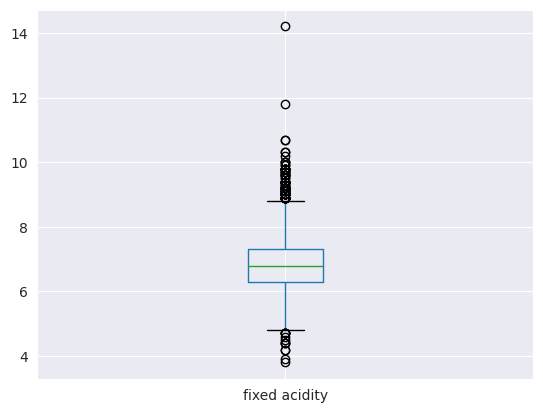

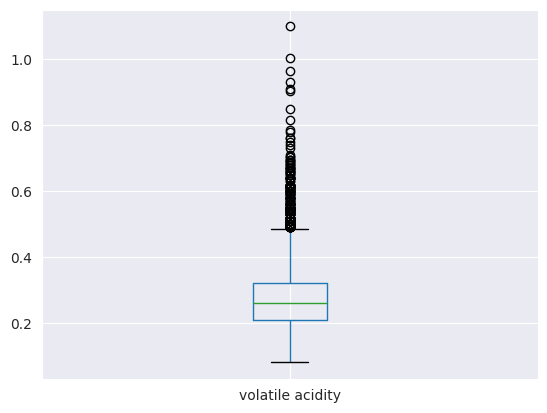

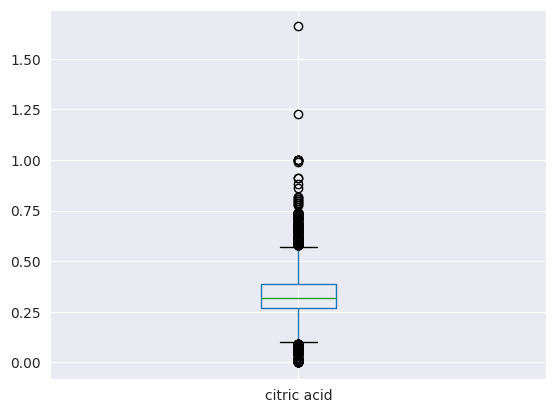

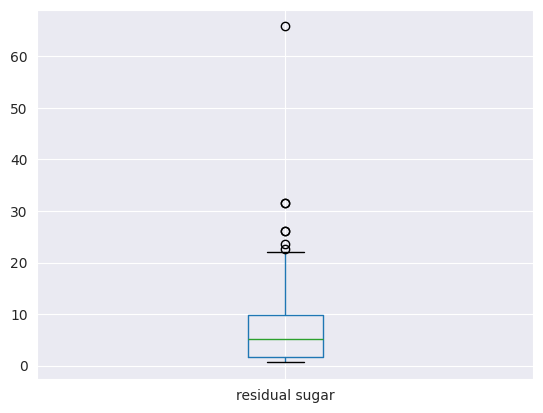

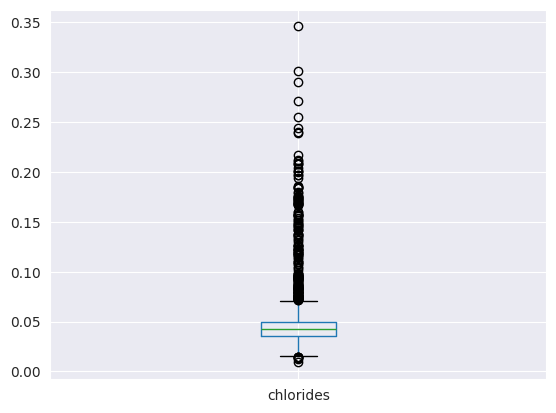

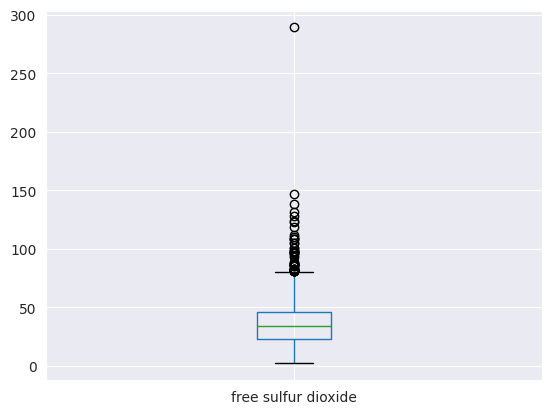

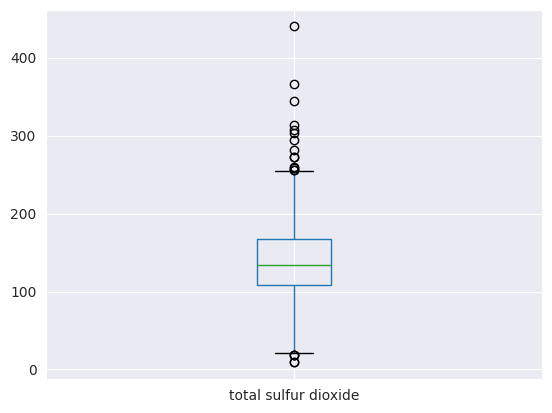

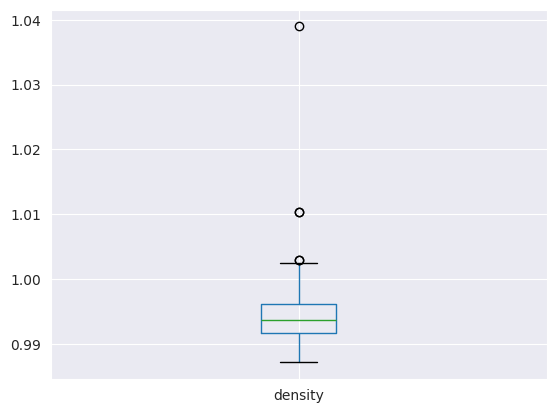

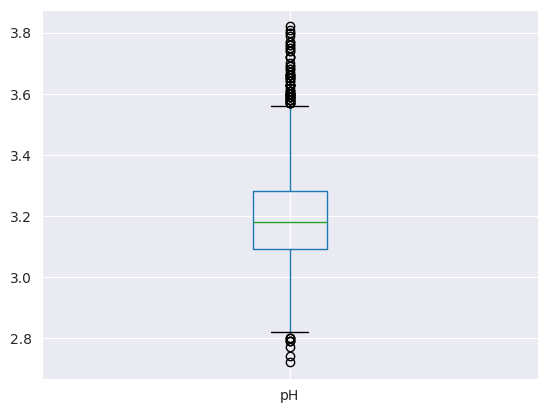

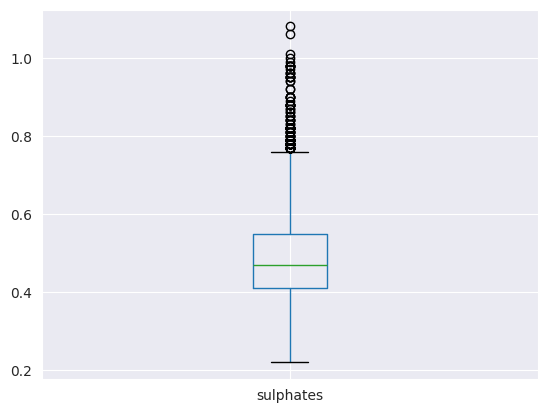

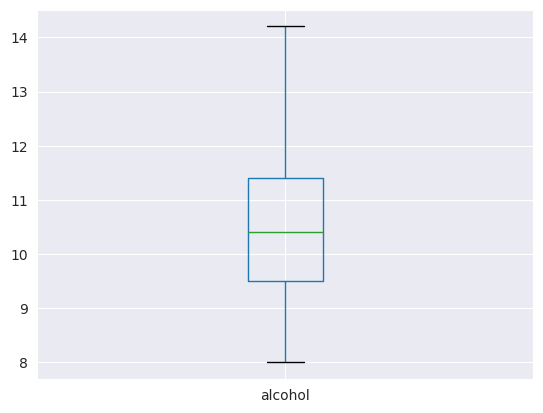

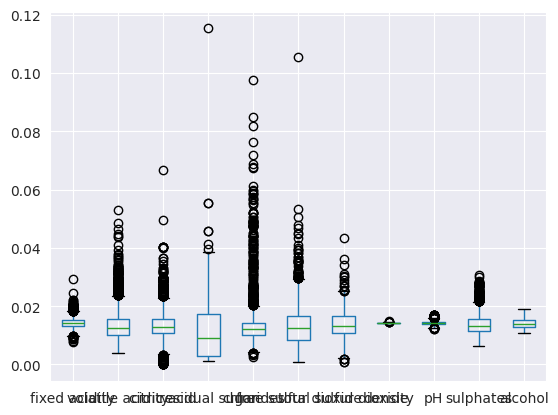

In [25]:
# add two boolean columns for "high quality" and "very high quality"
quality_values = df_w["quality"].values
hq = []
vhq = []
hqcount=0
vhqcount = 0
for quality in quality_values:
    if (quality < 7):
        hq.append(0)
        vhq.append(0)
    elif (quality <8):
        hqcount+=1
        hq.append(1)
        vhq.append(0)
    else:
        hqcount+=1
        vhqcount += 1
        hq.append(1)
        vhq.append(1)

df_w["high quality"]=hq
df_w["very high quality"]=vhq

#df_w.head()

# create copy with normalized data
df_w_norm = df_w.copy(deep=True)

col_list = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", 
            "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
for col in col_list:
    boxplot = df_w.boxplot(col)
    plt.show()
    x_array = np.array(df_w_norm[col])
    #print("" + col + ": " + str(min(x_array)) + " - " + str(max(x_array)))
    normalized_arr = preprocessing.normalize([x_array])
    #print("" + col + ": " + str(min(normalized_arr[0])) + " - " + str(max(normalized_arr[0])))
    df_w_norm[col]=normalized_arr[0]

boxplot = df_w_norm.boxplot(col_list)
plt.show()


Exploratory Data Analysis:

We will perform exploratory data analysis, beginning with a correlation matrix.


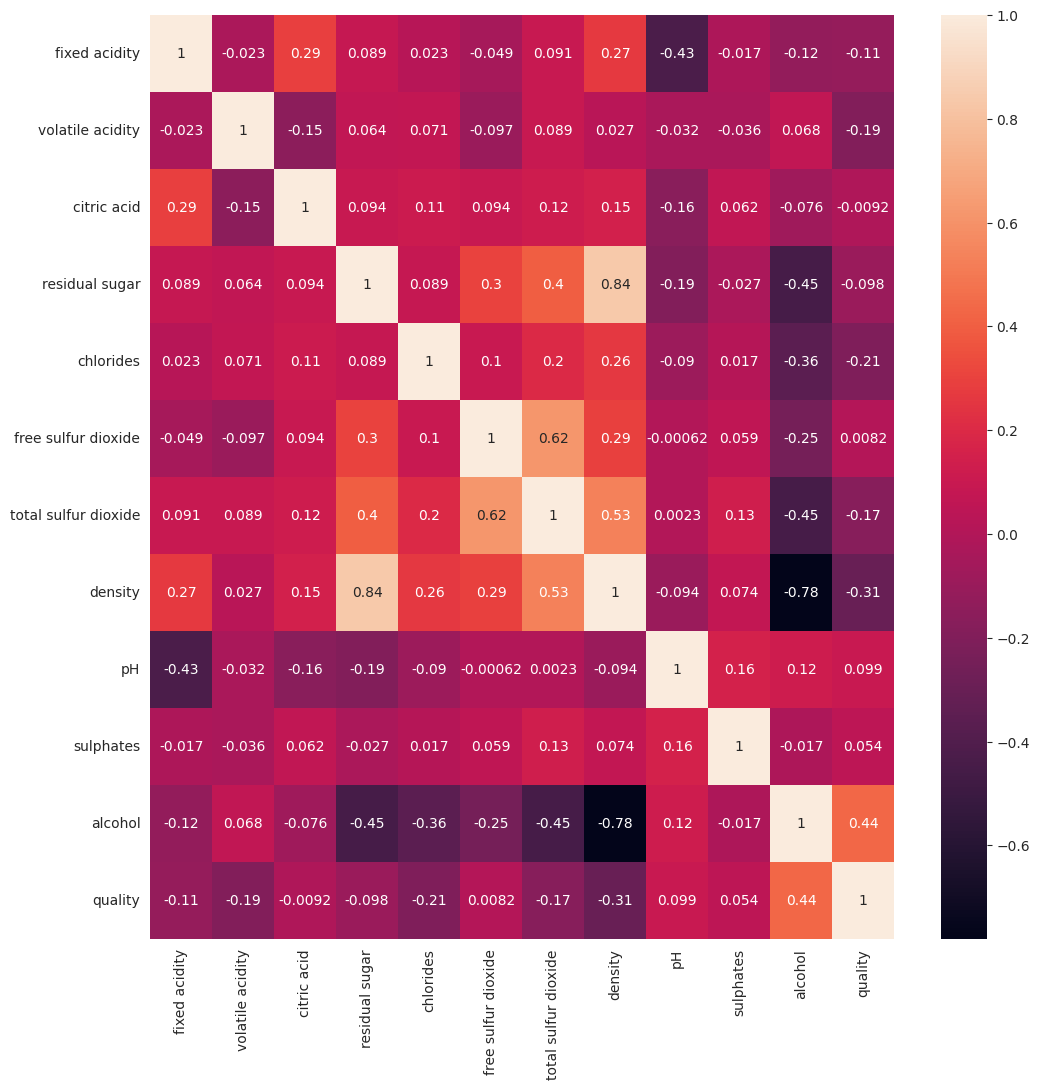

<Figure size 1200x1200 with 0 Axes>

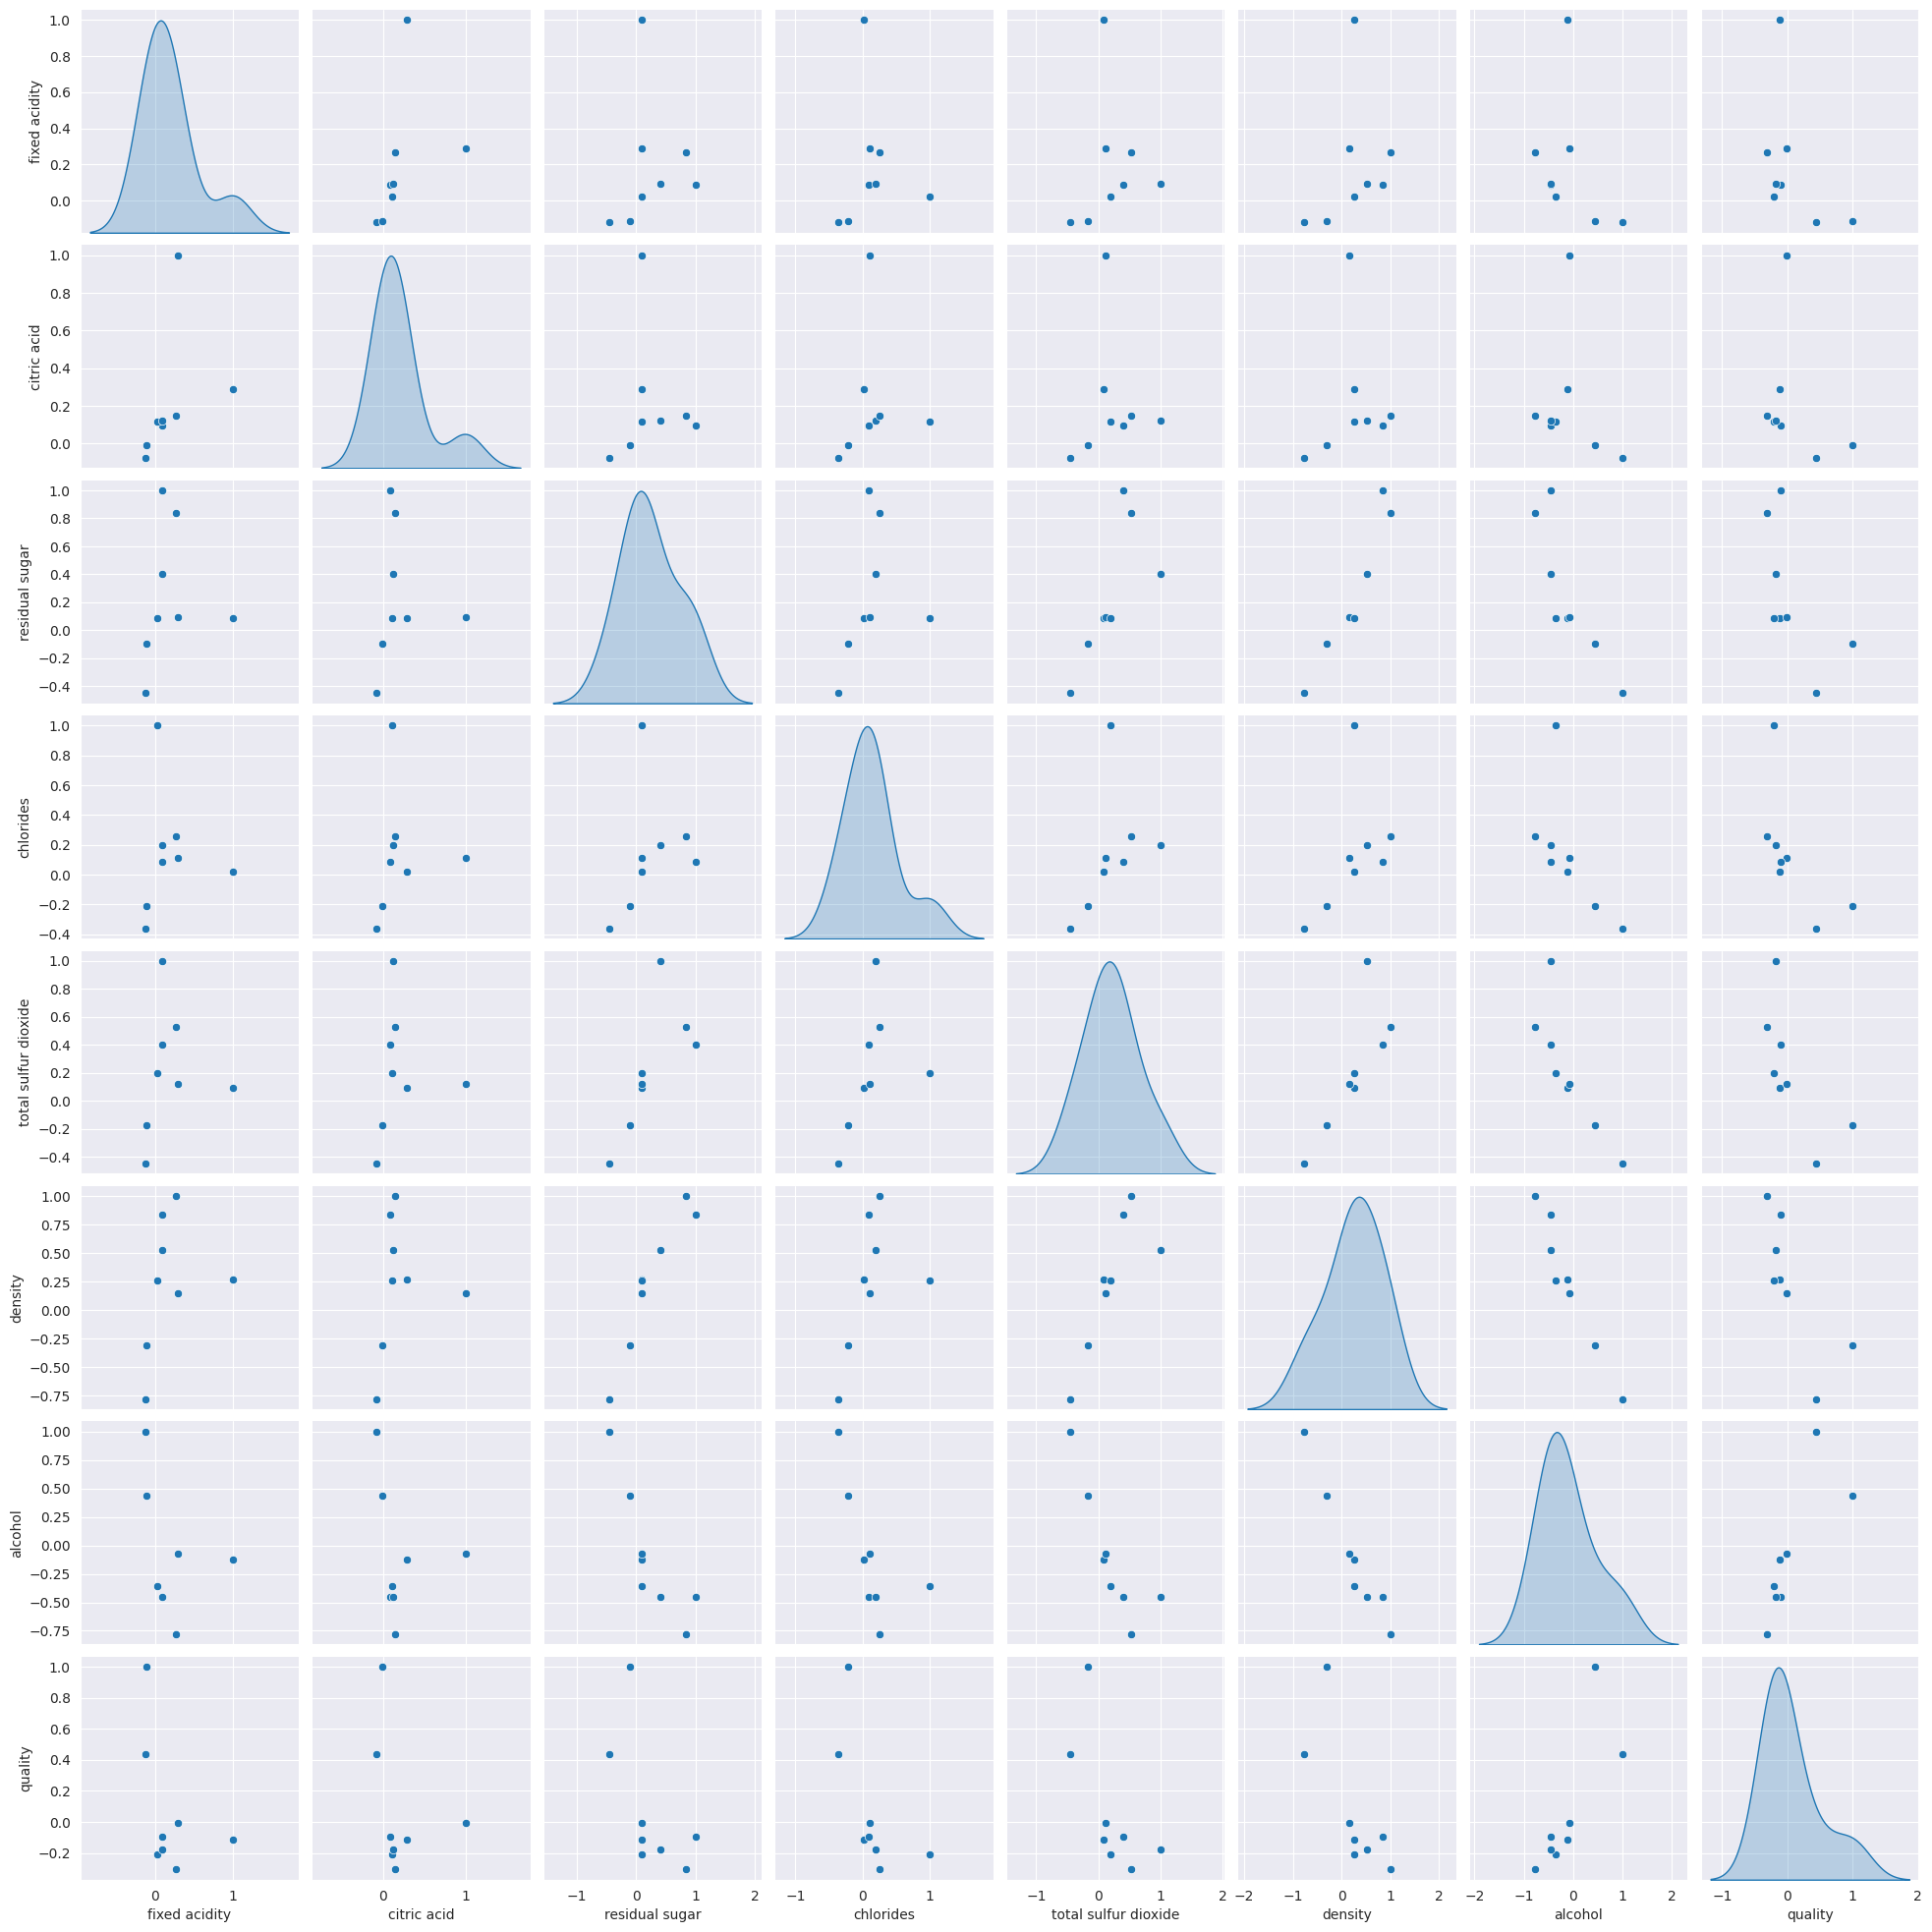

In [26]:
#df_w_norm.info()
plt.figure(figsize = (12,12))
df_w_norm_corr = df_w_norm.iloc[:, 0:12]
sns.heatmap(df_w_norm_corr.corr(), annot=True)
plt.show()

df_w_norm_corr = df_w_norm_corr.iloc[:, [0, 2, 3, 4, 6, 7, 10,11]]
plt.figure(figsize = (12,12))
sns.pairplot(df_w_norm_corr.corr(), diag_kind='kde')
plt.show()

Exploratory Data Analysis:

Quality:
With regard to quality, alcohol is most strongly correlated, with density, chlorides, volatile acidity and total sulfur dioxide having some negative correlation.  These are all in line with my expectations.

Density, Residual Sugar, and Alcohol:
These are all collinear, within my expectations.  As fermentation proceeds, sugar is converted to alcohol, resulting in a decrease in density.  

Total and Free Sulfur Dioxide:
These are correlated, as expected.  These are in equilibrium.

Citric acid and fixed acidity:
These are weakly correlated.  Citric acid is one of several sources of fixed acidity in wine.

Residual Sugar and Total/Free Sulfur Dioxide:
These are weakly correlated.  Residual sugar results from fermentation being stalled.  There are several reasons why this may happen, both intentional and unintentional on the part of the wine maker.  A common intentional reason involves the wine maker deliberately adding sulfur dioxide to kill the yeast and allow the wine to retain some sugar for sweetness.


First Model: Decision Tree

Introductory Comments: We will use a Decision Tree using the "high quality" field for the outcome.  Because we are using a decision tree, it is not necessary to address the collinearities identified during EDA.



In [27]:
#Helpful functions from Intro to Machine Learning Class:
def calculate_precision(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates precision for a binary classifier.
    
    Args
        y_true: np.ndarray
        y_pred: np.ndarray
        
        pos_label_value: (float) the number which represents the postiive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    
    
    # your code here
    pp=0
    tp=0
    for i in range(len(y_true)):
        if (y_true[i]==pos_label_value and y_pred[i]==pos_label_value): tp+=1
        if (y_pred[i]==pos_label_value): pp+=1
    
    
    return tp/pp

def calculate_recall(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates recall for a binary classifier.
    
    Args
        y_true: np.ndarray
        y_pred: np.ndarray
        
        pos_label_value: (float) the number which represents the postiive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    
    # your code here
    
    tp=0
    pos=0
    for i in range(len(y_true)):
        if (y_true[i]==pos_label_value and y_pred[i]==pos_label_value): tp+=1
        if (y_true[i]==pos_label_value): pos+=1
    
    return tp/pos

In [28]:
df_tree = df_w.copy(deep=True)
df_tree = df_tree.drop("quality", axis=1)
df_tree = df_tree.drop("very high quality", axis=1)

y = df_tree['high quality'].values
X = df_tree.drop("high quality", axis=1)

x_cols = X.columns
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
label_names=df_tree.columns.values

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

results = clf.predict(X_test)

prec = calculate_precision(results, y_test)
recall = calculate_recall(results, y_test)

print("Decision Tree Metrics:")
print("Accuracy:" + str(prec))
print("Recall:" + str(recall))


Decision Tree Metrics:
Accuracy:0.6740088105726872
Recall:0.6194331983805668


With random_state = 42, this gives an accuracy of 67.4%.  (Using different random states resulted in accuracy as low as 55% and as high as 70%)

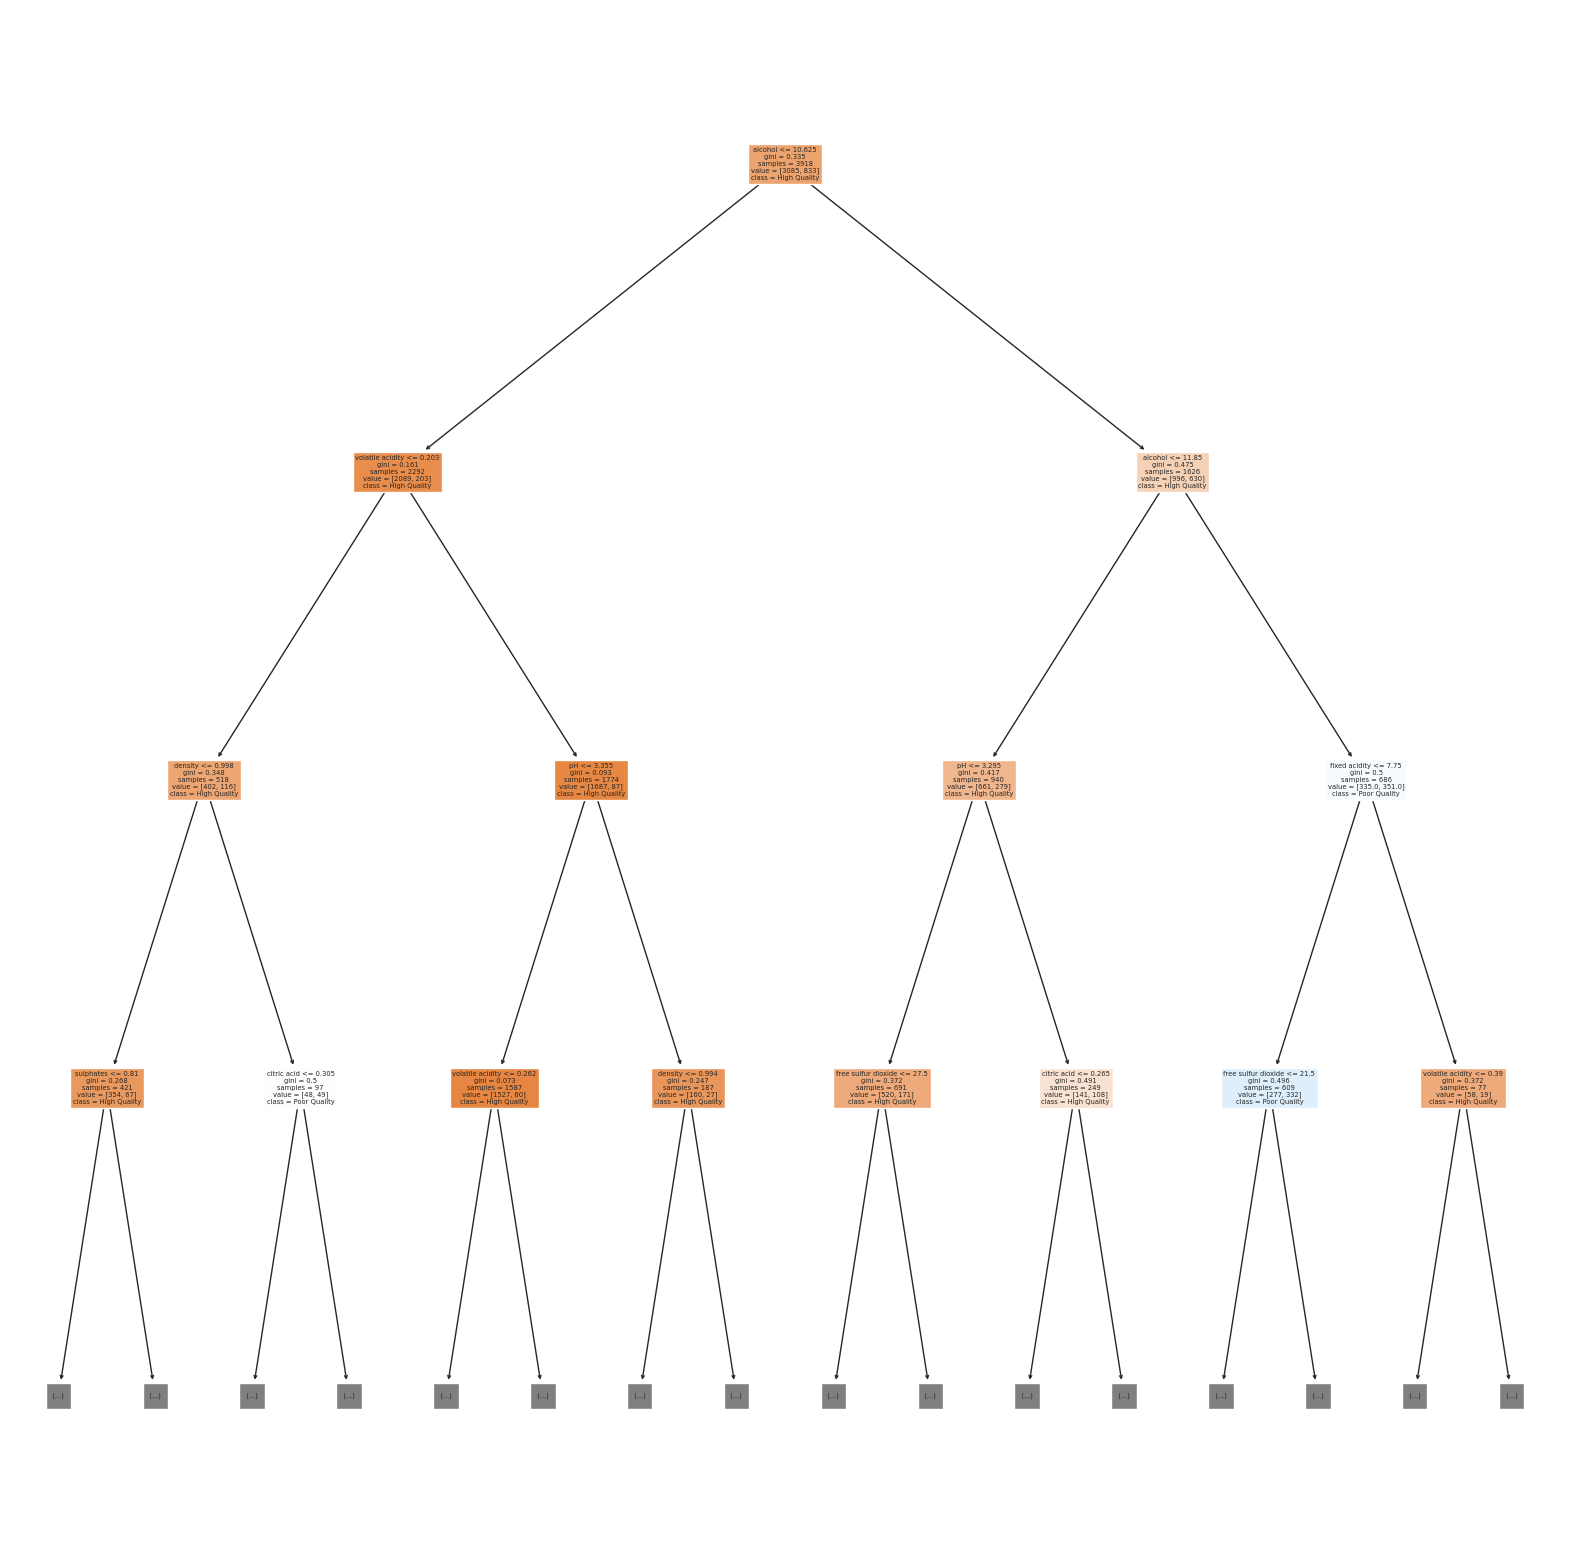

In [29]:
plt.figure(figsize = (20,20))
plot_tree(clf, max_depth=3, feature_names = label_names, class_names = ["High Quality", "Poor Quality"], filled=True)
plt.show()

Initial Model Evaluation:
The Decision Tree Classifier only achieves at best around 70% accuracy in predicting quality.  I tried adjusting parameters including max_deth and max_leaf_nodes and could not achieve a much better result.  Given the highly subjective nature of wine classification, perhaps this is the best that could be expected?

Reviewing the Decision Tree produced, it appears that the most important features identified by the classifier include alcohol, volatile acidity, ph, residual sugar, and free sulfur dioxide.  


2nd Model:

Let's see if we can improve accuracy by using XGBoost classifier and using GridSearchCV to find the best combination of parameters.

In [30]:
# initial XGBClassifier using default settings
bst = XGBClassifier()
bst.fit(X_train, y_train)
results = bst.predict(X_test)

prec = calculate_precision(results, y_test)
recall = calculate_recall(results, y_test)

print(prec)
print(recall)


0.6651982378854625
0.7947368421052632


Accuracy from XGBClassifier with default settings is worse than accuracy for DecisionTreeClassifier.  Let's try iteratively adjusting the parameters using GridSearchCV:

In [31]:
y = df_tree['high quality'].values
X = df_tree.drop("high quality", axis=1).values

bst = XGBClassifier()
parameters = {'max_depth':[3,4,5,6, 7, 8, 9, 10, 11, 12], 'gamma':[2**x for x in range(-5,6)], 'objective':['binary:logistic']}
grid = GridSearchCV(bst, parameters, cv=3).fit(X,y)



In [32]:
print(grid.best_params_)
print(grid.best_score_)


{'gamma': 8, 'max_depth': 3, 'objective': 'binary:logistic'}
0.7972580438584905


Initial Model Analysis:

The best parameters were gamma=8 and max_depth = 3.  With these parameters, prediction_accuracy is shows as 79.72 %.  Examining the prediction accuracy matrix reveals that most of the parameters achieved accuracy within a few percentage points of this.



RESULTS AND ANALYSIS:

Due to the balanced nature of the data, I chose accuracy as the evaluation metric.  

Comparing the two models, the initial XGBoost Classifier considerably underperformed the Decision Tree Classifier.  However, upon optimizing the parameters through GridSearchCV, the best XGBoost Classifier gave excellent results, outstripping the Decision Tree Classifier by around 10%.  

Let's evaluate the XGBoost best estimator tree to consider which factors it found important:

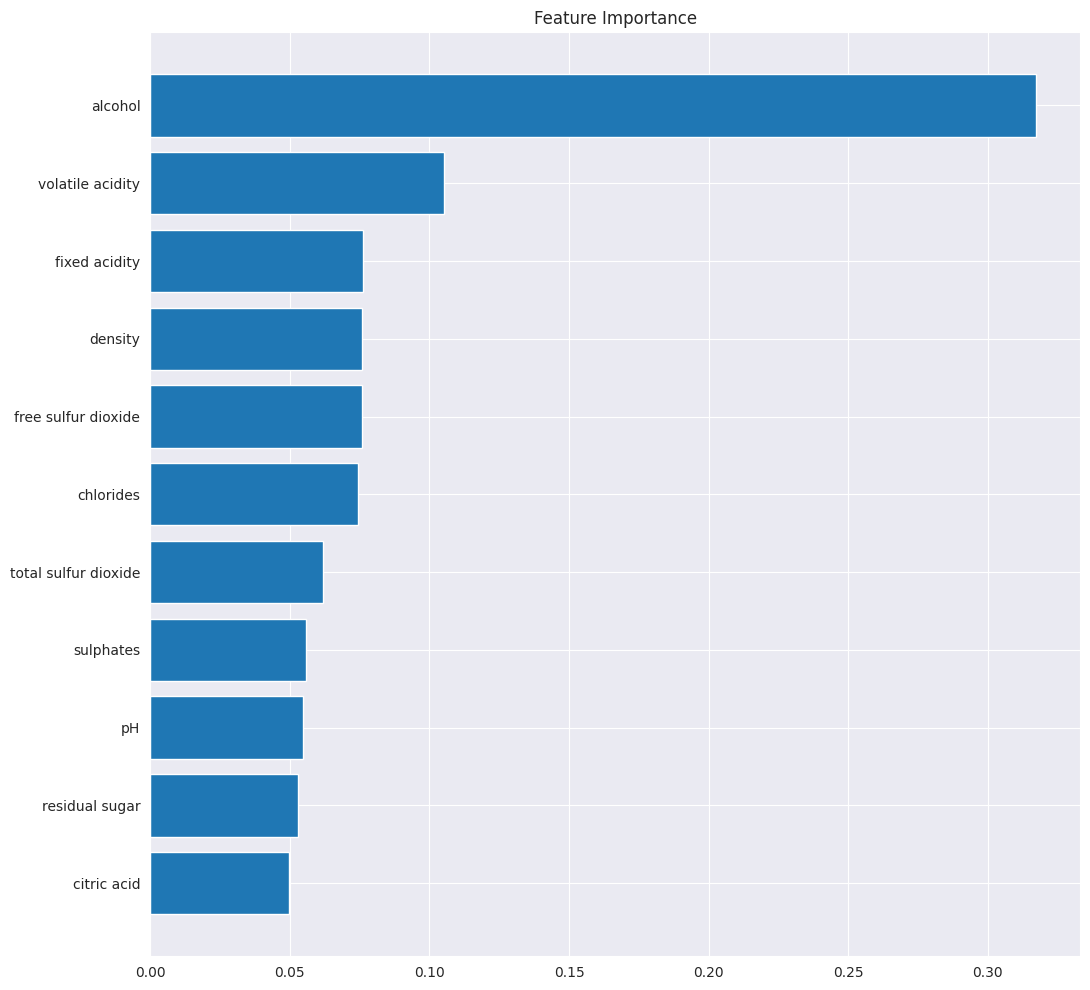

In [33]:
bst = grid.best_estimator_
feature_importance = bst.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12,12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_cols)[sorted_idx])
plt.title("Feature Importance")
plt.show()

RESULTS AND ANALYSIS: FEATURE IMPORTANCE

By far, the most important feature is alcohol content.  Going back to our original 10 point quality scale, let's graph alcohol content against quality:



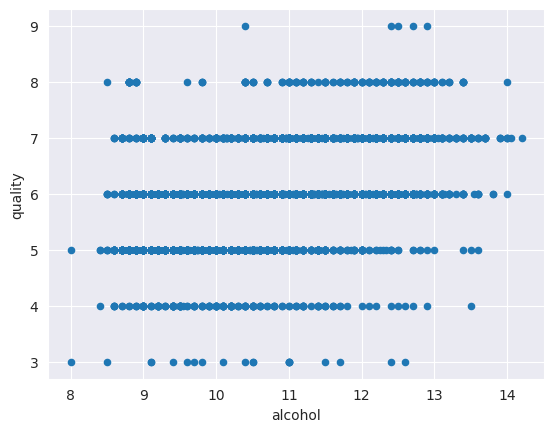

In [34]:
df_w.plot.scatter(x='alcohol', y='quality')
plt.show()

Remember that we defined "high quality" to be quality 7 and above.  There are very few quality 9 wines, but with only one exception they all fall into a tight range of alcohol content (12.5-13%).  With a few outliers, most quality 8 wines contain between 10.5 and 13% alcohol.  Quality 7 has a broader range of alcohol levels.

Let's evaluate the first few tree levels:


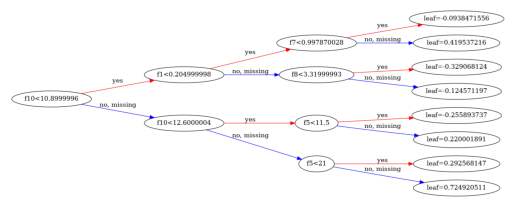

In [49]:
xgplot_tree(bst, rankdir='LR')
plt.show()

Looking at the top few nodes, we see that the very first decisions relate to alcohol content being between 10.9 and 12.6.  For alcohol contents below this range, the next most important feature is volatile acidity (below .20).   Free Sulfur Dioxide becomes important, but with the level becoming less critical at higher alcohol levels.  Looking deeper into the tree, it seems that in many cases, high alcohol content can compensate for defects in the wine which might be more noticeable at lower alcohol levels.


DISCUSSION AND CONCLUSION

First, I was pleasantly surprised by the accuracy I was able to achieve with the XGBoost model.  The project could be improved by examining the original study to see how the quality rating was determined.  I had suspected that the quality would be highly subjective and perhaps influenced by external factors, such as price.  While there may be elements of that at higher granularity, I was pleased to see that by dividing quality into just two categories, the model was able to predict quality with a high level of accuracy.

The project was not as successful as I might have hoped in identifying specific things to avoid.  For instance, I know that having an extremely high level of Sulfur Dioxide introduced early in the wine making process will kill the fermentation at very low alcohol levels, leaving very high residual sugar.  Samples like this existed, but in small enough quantities that they did not make much impact on the decision tree or XGBoost trees.  If I had instead divided the wine qualities into "Bad" at levels 0-3, and "Not bad" at 4-10, perhaps these would have been more strongly highlighted.  

One aspect of the project which did not work well was the train test split method for the Decision Tree Classifier.  Using 20% of the data for testing and 80% of the data for training resulted in a very wide range of prediction accuracies depending on which data was selected.  By running this step repeatedly, I was able to approximate a best result, and then found a random_state which came close to that number.  This section of the project could have been improved by using cross-validation.

Finally, the project could be improved in several ways.  It would be worth exploring how well XGBoost would do at predicting the original quality scores on the 0-10 scale.  It could also be worth rerunning all components of the current notebook but with "high quality" set to 8+ instead of 7+.  Since the alcohol range of 8+ quality wines was much tighter than the quality 7 wines, focusing on the feature importance at that quality level might be informative.  Last, the project could be improved by considering additional models, such as using SVM to predict on the original 0-10 quality scale.
